In [1]:
from __future__ import print_function

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import csv
import os
import sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# file reader function: read file by concating chunks
def file_reader(file_path, num_rows=None, chunksize=None):
    if chunksize is None:
        return pd.read_csv(file_path, encoding='gbk', nrows=num_rows, chunksize=chunksize)
    else:
        chunks = pd.read_csv(file_path, encoding='gbk', nrows=num_rows, chunksize=chunksize)
        return pd.concat(chunks)

In [4]:
# get file path
def get_absolute_file_path(folder_name, file_name):
    return os.path.join(os.path.dirname(os.getcwd()), folder_name, file_name)

In [5]:
# set up all file path
user_file_path = get_absolute_file_path('data', 'JData_User.csv')
product_file_path = get_absolute_file_path('data', 'JData_Product.csv')
comment_file_path = get_absolute_file_path('data', 'JData_Comment(修正版).csv')
action_02_file_path = get_absolute_file_path('data', 'JData_Action_201602.csv')
action_03_extra_file_path = get_absolute_file_path('data', 'JData_Action_201603_extra.csv')
action_03_file_path = get_absolute_file_path('data', 'JData_Action_201603.csv')
action_04_file_path = get_absolute_file_path('data', 'JData_Action_201604.csv')

In [8]:
# read files
product_file = file_reader(product_file_path, None)
comment_file = file_reader(comment_file_path, 10)
action_02_file = file_reader(action_02_file_path, 10)
action_03_extra_file = file_reader(action_03_extra_file_path, 10)
action_03_file = file_reader(action_03_file_path, 10)
action_04_file = file_reader(action_04_file_path, 10)

In [9]:
print('Unique User ID:', len(pd.unique(product_file['sku_id'])))

Unique User ID: 24187


# Basic Statistical Description

## User Profile Detection

In [48]:
# user file
user_file = file_reader(user_file_path)
user_file.head()

,user_id,age,sex,user_lv_cd,user_reg_dt
0,54,-1,2,1,2016/1/26
1,79,36-45岁,2,2,2016/1/27
2,100,16-25岁,2,3,2016/1/27
3,266,15岁以下,2,2,2016/1/29
4,333,-1,2,4,2016/1/30


In [49]:
print('User File Length:', len(user_file))
print('Unique User ID:', len(pd.unique(user_file['user_id'])))

('User File Length:', 103616)
('Unique User ID:', 103616)


User file stores all unique user data, totally 103616

In [50]:
# age distribution
def age_distribution(filename):
    age_cate = pd.unique(filename['age'])
    age_to_code = {}
    code_to_age = {}
    for code, age in enumerate(age_cate):
        if '-1' in age:
            age_to_code[age] = 0
            code_to_age[0] = age
        if '15' in age:
            age_to_code[age] = 1
            code_to_age[1] = age
        if '16' in age:
            age_to_code[age] = 2
            code_to_age[2] = age
        if '26' in age:
            age_to_code[age] = 3
            code_to_age[3] = age
        if '36' in age:
            age_to_code[age] = 4
            code_to_age[4] = age
        if '46' in age:
            age_to_code[age] = 5
            code_to_age[5] = age
        if '56' in age:
            age_to_code[age] = 6
            code_to_age[6] = age
            
    # count age
    age_count = pd.DataFrame(pd.Series.value_counts(filename['age']))
    age_count = age_count.reset_index()
    age_count.columns = ['cate', 'count']
    age_count['code'] = age_count['cate'].apply(lambda x: age_to_code[x])
    age_count

    # plot
    sns.barplot(age_count['code'], age_count['count'])

    return age_count

,cate,count,code
0,26-35岁,46525,3
1,36-45岁,30828,4
2,-1,12803,0
3,16-25岁,7999,2
4,46-55岁,3407,5
5,56岁以上,2048,6
6,15岁以下,6,1


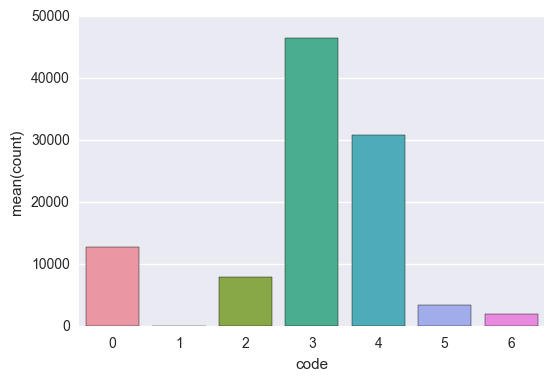

In [51]:
# plotting
age_count = age_distribution(user_file)
age_count

0: unknown, 1: below 15, 2: 16-25, 3: 26-35, 4: 36-45, 5: 46-55, 6: above 56  
From the figure above, most of people are 25-45. Quite a number of people don't show ages. The distribution is not like Gaussian,  
but almost there

In [52]:
# sex statistics
def sex_distribution(filename):
    print pd.Series.value_counts(filename['sex'])
sex_distribution(user_file)

2    50484
0    45547
1     7585
Name: sex, dtype: int64


In [53]:
# user_lv_cd 用户等级
def user_cd_distribution(filename):
    print pd.Series.value_counts(filename['user_lv_cd'])
user_cd_distribution(user_file)

5    39875
4    32205
3    21689
2     7519
1     2328
Name: user_lv_cd, dtype: int64


(array([   0,    1,    2, ..., 3509, 3510, 3511]),
 <a list of 3512 Text xticklabel objects>)

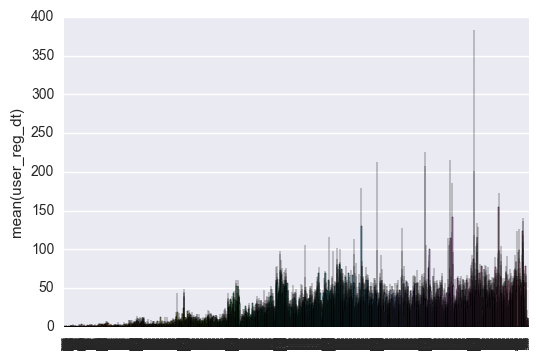

In [54]:
# register date
df = pd.DataFrame(pd.Series.value_counts(user_file['user_reg_dt']))
df.sort_index(inplace = True)
sns.barplot(df.index, df['user_reg_dt'])
plt.xticks(rotation = 90, fontsize = 2)

$\textbf{Most of users have registered in recent years.}$

## Product Information

In [32]:
product_file.head()

,sku_id,attr1,attr2,attr3,cate,brand
0,166731,1,-1,-1,8,545
1,146488,2,2,-1,8,812
2,70546,3,1,1,8,214
3,92487,2,2,-1,8,812
4,113065,2,2,-1,8,812


In [33]:
comment_file.head()

,dt,sku_id,comment_num,has_bad_comment,bad_comment_rate
0,2016-02-01,83714,4,1,0.0393
1,2016-02-01,125225,3,1,0.0833
2,2016-02-01,76379,4,1,0.0328
3,2016-02-01,150212,1,0,0.0000
4,2016-02-01,123004,2,0,0.0000


In [34]:
action_04_file.head()

,user_id,sku_id,time,model_id,type,cate,brand
0,100259,159398,2016-04-01 19:33:47,NaN,6,4,752
1,100259,159398,2016-04-01 19:33:55,NaN,6,4,752
2,100259,159398,2016-04-01 19:28:37,NaN,6,4,752
3,100259,159398,2016-04-01 19:33:18,NaN,6,4,752
4,56097,32453,2016-04-01 06:57:37,NaN,6,9,640


## Cluster product

In [84]:
product_file_path = get_absolute_file_path('data', 'JData_Product.csv')
product_file = file_reader(product_file_path, None)

In [85]:
product_file.hist(alpha=0.5)

<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1232a1dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124b77390>]], dtype=object)

## Sample dataset

### Generate small sample datasets

In [3]:
def generate_small_sample_set(frac=0.1, random_state=100):
    user_file_path = get_absolute_file_path('data', 'JData_User.csv')
    user_file = file_reader(user_file_path, None)
    sampled_user_info = user_file.sample(frac=frac, random_state=random_state)
    sampled_user = sampled_user_info['user_id']
    
    # see sample information
    age_distribution(sampled_user_info)
    sex_distribution(sampled_user_info)
    user_cd_distribution(sampled_user_info)
    
    action_file_name_list = [
        'JData_Action_201602.csv', 
        'JData_Action_201603_extra.csv', 
        'JData_Action_201603.csv', 
        'JData_Action_201604.csv']
    
    filtered_action_file = list()
    for action_file_name in action_file_name_list:
        print('loading {}'.format(action_file_name))
        action_file_path = get_absolute_file_path('data', action_file_name)
        action_file = file_reader(action_file_path, None)
        filtered_action_file.append(action_file.loc[action_file['user_id'].isin(sampled_user)])
        
    return pd.concat(filtered_action_file, ignore_index=True)

<IPython.core.display.Javascript object>


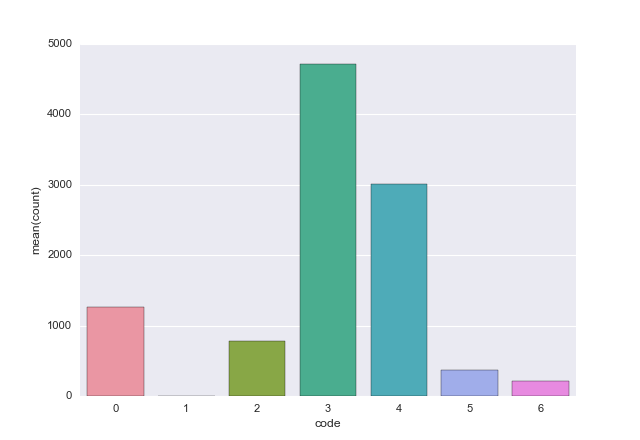

2    5068
0    4551
1     743
Name: sex, dtype: int64
5    3969
4    3169
3    2266
2     744
1     214
Name: user_lv_cd, dtype: int64
loading JData_Action_201602.csv
loading JData_Action_201603_extra.csv
loading JData_Action_201603.csv
loading JData_Action_201604.csv


,user_id,sku_id,time,model_id,type,cate,brand
0,88047,12037,2016-02-01 15:16:36,NaN,6,4,752
1,88047,12037,2016-02-01 15:16:37,NaN,6,4,752
2,85421,106487,2016-02-01 06:27:35,NaN,6,4,800
3,85421,106487,2016-02-01 06:30:47,NaN,6,4,800
4,85421,106487,2016-02-01 06:27:21,NaN,6,4,800


In [16]:
sampled_training_set = generate_small_sample_set(frac=0.10)

In [5]:
# save sample data
sampled_training_set.head()
sampled_training_set.to_csv('sample_data.csv', index = False)

### Sample Data Analysis

In [10]:
# read sample dataset
sample = pd.read_csv('sample_data.csv')

In [11]:
users = pd.unique(sample['user_id'])
skus = pd.unique(sample['sku_id'])
print('Number of Users:', len(users))
print('Number of Products:', len(skus))

Number of Users: 10354
Number of Products: 19103


### Model (for a specific product):   
$$Score = w_0 \cdot freq + \sum\limits_{i=1}^6 w_{i}\cdot type_i*time_i + w_7 \cdot Eval + b \hspace{1cm} (1)$$

where $w_{i}$ is the weight of type, $w_{t}$ is the weight of time for that action type  
$Eval$ is the total evaluation of that product  
$freq$ is the frequency of that product bought, which can be calculated by $freq = \frac{Count}{Total History Days}$  
$time$ is the time range index  
Predict the product users are likely to buy in the next five days based on the maximum score

### Initial Trial

In [12]:
# build four dictionary
user_to_code = {u:c for c, u in enumerate(users)}
code_to_user = {c:u for c, u in enumerate(users)}
skus_to_code = {s:c for c, s in enumerate(skus)}
code_to_skus = {c:s for c, s in enumerate(skus)}

# rating criterion based on action type
# could be changed
# Action评分标准
# 浏览 1, 点击 2, 关注 3, 加入购物车 4, 下单 5, 从购物车删除 -3 (说明之前感兴趣，又不买了，但是确实浏览过)
# 时间关系: 最近下单的商品在之后5天再次购买几率会很小，而最近加入购物车的商品之后购买概率最高，点击，浏览关注的购买几率上升
# idea: 分为几个时间段，进行penalize或者给权重 （结果是之后5天购买的可能性，所以可以选5天为一个时间区间）

# to be discussed
type_to_rating = {1: 1, 2: 4, 3: -3, 4: 5, 5: 3, 6: 2}

# action type rating
sample['rating'] = sample['type'].apply(lambda x: type_to_rating[x])

In [13]:
# extract date information and eliminate the specific time
sample['date'] = sample['time'].apply(lambda x: x.split(" ")[0])

In [14]:
date_unique = pd.unique(sample['date'])
total_day = len(date_unique)
num_interval = total_day / 5.

# key is the range of date, value is the weights of different action
time_weight = {}
time_to_code = {}

idx = 0
pointer = 1

# 权重的值应该基于用户历史记录而定, 待定
while idx < total_day:
    key = date_unique[idx:idx+5]
    time_to_code[tuple(key)] = pointer
    value = {1: float(pointer)/total_day, 2: float(pointer+4)/total_day, \
             3: -float(pointer)/total_day, 4: 1-float(pointer)/total_day, 5: float(pointer+2)/total_day, 6: float(pointer+1)/total_day}
    
    time_weight[pointer] = value
    idx += 5
    pointer += 1

In [15]:
def calculate_date_index(group):
    for key in time_to_code:
        if group in key:
            return time_to_code[key]
sample['date_index'] = sample['date'].apply(lambda x: calculate_date_index(x))

In [16]:
t_weight = []
for t, d in zip(sample['type'], sample['date_index']):
    t_weight.append(time_weight[d][t])
sample['time_weight'] = t_weight

#### Train & Test Split and Analysis

In [17]:
# first trial based on type and time_weight

# split train & test
last_five = 15
test = sample[sample['date_index'] == last_five]
train = sample.loc[~sample.index.isin(test.index)]
test = test[test['type'] == 4]
train_data = train[train['user_id'].isin(test['user_id'])]

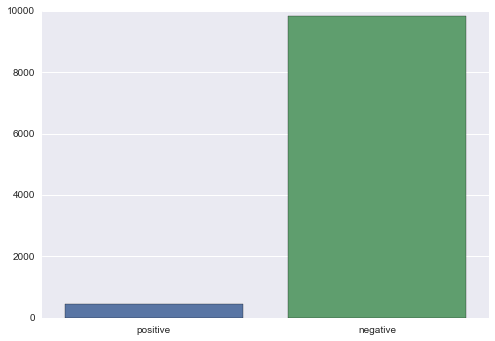

In [18]:
# sample data analysis

# positive sample (4-11 to 4-15 bought products)
# negative sample (other products, all products - positive sample)
user_positive = train_data['user_id']
user_negative = train[~train['user_id'].isin(train_data['user_id'])]['user_id']
sns.barplot(['positive', 'negative'], [len(pd.unique(user_positive)), len(pd.unique(user_negative))])

$\textbf{train data 中取出 4-11 to 4-15 有发生购买行为的user的历史记录， 这类user和没有发生购买行为的user存在严重的不平衡，从上图看出相对历史记录来说，  sample中相当少的用户}$ 
$\textbf{有在4-11 to 4-15有发生购买行为, 但是我们的目的是预测接下来5天，所有用户最有可能购买的商品，所以sample data需要进一步筛选}$  
$\textbf{最好的是} \frac{负样本}{正样本} = 1:1 or 2:1$

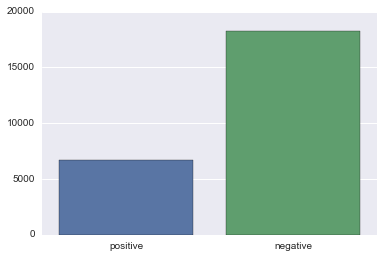

In [33]:
product_positive = train_data['sku_id']
product_negative = train[~train['user_id'].isin(train_data['user_id'])]['sku_id']
sns.barplot(['positive', 'negative'], [len(pd.unique(product_positive)), len(pd.unique(product_negative))])

$\textbf{train data 中 产品的分布也有类似的趋势， 不过更接近2:1}$

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text xticklabel objects>)

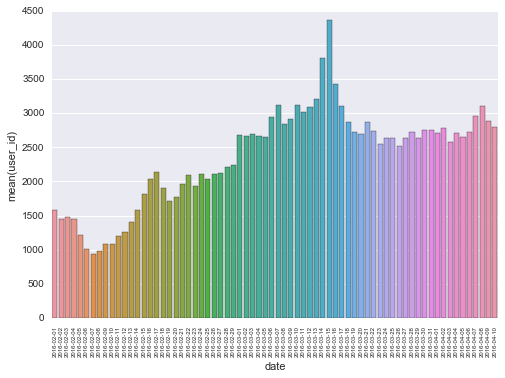

In [20]:
# 发生行为用户数量随时间分布

# groupby date
user_time_df = train[['date', 'user_id']].groupby(['date']).agg(lambda x: len(set(x)))
sns.barplot(user_time_df.index, user_time_df['user_id'])
plt.xticks(rotation = 90, fontsize = 6)

$\textbf{可发现，用户数量在3月份后基本接近平衡状态 可以考虑只用最近近一个月或者一个半月的数据进行预测}$

$\textbf{由以上图可知，样本单纯的random取样是不足够的，需要进一步筛选和取样，才能实现更好的模型结果}$

#### Simple Test

In [34]:
test_data = test[['user_id', 'sku_id']].groupby(['user_id']).agg(lambda x: set(x))
test_data.head()

,sku_id
user_id,
910,{75588}
941,{161883}
1128,{74499}
1304,{107012}
1500,{54357}


In [35]:
train_data['score'] = train_data['rating']*train_data['time_weight']
train_data.head()

/Users/sunjiajun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,user_id,sku_id,time,model_id,type,cate,brand,rating,date,date_index,time_weight,score
0,88047,12037,2016-02-01 15:16:36,NaN,6,4,752,2,2016-02-01,1,0.026667,0.053333
1,88047,12037,2016-02-01 15:16:37,NaN,6,4,752,2,2016-02-01,1,0.026667,0.053333
2,85421,106487,2016-02-01 06:27:35,NaN,6,4,800,2,2016-02-01,1,0.026667,0.053333
3,85421,106487,2016-02-01 06:30:47,NaN,6,4,800,2,2016-02-01,1,0.026667,0.053333
4,85421,106487,2016-02-01 06:27:21,NaN,6,4,800,2,2016-02-01,1,0.026667,0.053333


In [37]:
# consider frequency
freq = train[['user_id', 'sku_id', 'score']].groupby(['user_id', 'sku_id']).agg(['count'])
# freq = freq['score']['count'] / total_day
freq.index[10]

(2, 43628)

In [37]:
result = train_data[['user_id', 'sku_id', 'score']].groupby(['user_id', 'sku_id']).agg(lambda x: max(x))
result = result.reset_index()
unique_users = pd.unique(result['user_id'])
buy_list = {}
for user in tqdm(unique_users):
    user_data = result[result['user_id'] == user]
    dic = {}
    for sku, score in zip(user_data['sku_id'], user_data['score']):
#         if sku == 75588 and user == 910: print score
#         if sku == 22962 and user == 910: print score
        dic[sku] = freq[user][sku] # pure frequency
    
    import operator
    sorted_dic = sorted(dic.items(), key = operator.itemgetter(1), reverse = True)
    buy_list[user] = sorted_dic[0][0] # 先都取第一个

KeyboardInterrupt: 

In [38]:
train_result = pd.DataFrame([buy_list]).transpose()
train_result.columns = ['sku_id']
train_result.head()

,sku_id
910,75588
941,80030
1128,96887
1304,109726
1500,162573


In [39]:
test_data.head()

,sku_id
user_id,
910,{75588}
941,{161883}
1128,{74499}
1304,{107012}
1500,{54357}


In [40]:
# accuracy
correct = 0
for idx in train_result.index:
    pred_sku = train_result.loc[idx][0]
    true_sku = test_data.loc[idx][0]
    if pred_sku in true_sku:
        correct += 1
print('accuracy:', correct / float(len(train_result)))

accuracy: 0.1978021978021978


In [53]:
true_positive = 0

for idx in train_result.index:
    pred_sku = train_result.loc[idx][0]
    true_sku = test_data.loc[idx][0]
    if pred_sku in true_sku:
        true_positive += 1
        
false_positive = 0

for idx in train_result.index:
    pred_sku = train_result.loc[idx][0]
    true_sku = test_data.loc[idx][0]
    if pred_sku not in true_sku:
        false_positive += 1
        
false_negative = 0

for idx in train_result.index:
    pred_sku = train_result.loc[idx][0]
    true_sku = test_data.loc[idx][0]
    for sku in true_sku:
        if sku not in {pred_sku}:
            false_negative += 1


In [54]:
presision = true_positive/(true_positive + false_positive)
recall = true_positive/(true_positive + false_negative)

In [58]:
F11 = 6*recall*presision/(5*recall+presision)
F12 = 5*recall*presision/(2*recall+3*presision)
print('F1_1 is {}, F1_2 is {}'.format(F11, F12))

F1_1 is 0.19108280254777069, F1_2 is 0.17557549746390944


#### Model Train & Prediction

$\textbf{思路：首先，train data的进一步清洗和筛选，根据4-11 to 4-15发生购买行为的用户，train一组weight出来。之前的test应该不能叫test, 应该是Y， 也就是相当于label， 我们要保证train中的data sku positive & negative的平衡，   user只用4-11 to 4-15有发生购买行为的}， X部分的数据可以考虑只取近一个月的或者一个半月的$

In [9]:
# reread sample data
# sample = pd.read_csv('sample_data.csv')
# sample['date'] = sample['time'].apply(lambda x: x.split(" ")[0])
len(sorted(pd.unique(sample['date']))[30:])

45

In [ ]:
class preprocess(object):
    
    def __init__(self):
        self.sample = None
        self.train = None
        self.test = None
    
    '''READ DATA'''
    def read_data(self):
        self.sample = pd.read_csv('sample_data.csv')
    
    '''Add DATE INDEX RANGE'''
    def date_index(self, cut_index=30):
        
        # extract date info
        self.sample['date'] = self.sample['time'].apply(lambda x: x.split(" ")[0])
        
        # filter data before 03-01
        unique_date = sorted(pd.unique(self.sample['date'])) # sort by date ascending
        effective_date = unique_date[cut_index:] # get 03-02 to 04-15
        self.sample = self.sample[self.sample['date'].isin(effective_date)]
        
        '''ASSIGN DATE INDEX'''
        
        # build date index dictionary
        total_days = len(effective_date)
        date_index_dict = {}
        idx = 0
        date_index = 0
        while idx < total_days:
            date_range = effective_date[idx:idx+5]
            date_index_dict[date_range] = date_index
            idx += 5
            date_index += 1
        
        # assign date index to corresponding date
        def calculate_date_index(group):
            for key in date_index_dict:
                if group in key:
                    return date_index_dict[key]
            self.sample['date_index'] = self.sample['date'].apply(lambda x: calculate_date_index(x))
    
    '''TRAIN & TEST SPLIT (INPUT DATE RANGE FOR TESTING)'''
    def train_test_split(self, date):
        self.test = self.sample[self.sample['date'].isin(date)]
        train = self.sample[~self.sample['date'].isin(date)]
        self.train = train[train['user_id'].isin(self.test['user_id'])]
        
    '''CREATE X MATRIX FOR EACH USER'''
    def create_X(self):
        Xlist = []
        unique_user = pd.unique(self.train['user_id'])
        for user in unique_user:
            user_data = self.train[self.sample['user_id'] == user]
            bought_items = pd.unique(user_data['sku_id'])
            X = np.array(
    
                

In [ ]:
class linearModel(object):
    
    def __init__(self):
        pass
    
    def train(self, Xtrain, ytrain): # train weights
        pass
    
    def pred(self, ytrue): # use JD evaluation metrics
        pass
    

## Number of products sold by time

<IPython.core.display.Javascript object>


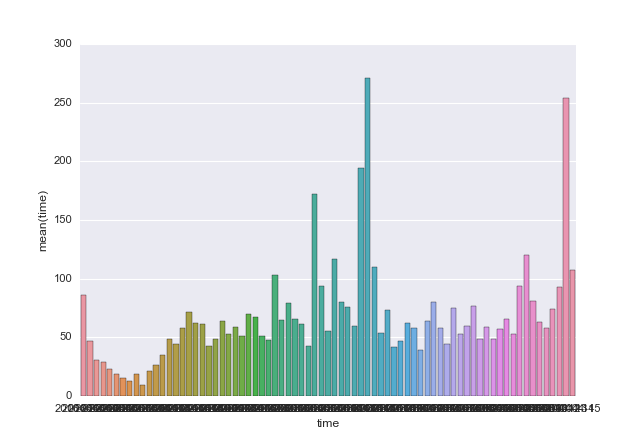

In [89]:
sold_product = sampled_training_set.loc[sampled_training_set['type']==4]
sales_by_time = sold_product.groupby(pd.to_datetime(sold_product['time']).dt.date).count()
sns.barplot(sales_by_time.index, sales_by_time.time)


## Baseline
First start with a simple rule_based model use a user's most recent actions frequency to predict its next purchase action 

In [83]:
def generate_training_data(action_file):
    grouped_action = pd.DataFrame(action_file.groupby(['user_id', 'sku_id', 'type']).size().rename('counts'))
    grouped_action = grouped_action.reset_index()
    return grouped_action

In [77]:
action_04 = file_reader(action_04_file_path, None, 1000)

In [85]:
training_samples = generate_training_data(action_04)
training_samples.head()

,user_id,sku_id,type,counts
0,1,124997,1,10
1,1,124997,6,11
2,2,4919,1,2
3,2,4919,6,3
4,2,7746,1,6


In [ ]:
def rule(candidates):
    

def rule_based_prediction(training_samples):
    pred = dict()
    for user_id in training_samples:
        sku_id = rule(training_samples[user_id])
        pred[user_id] = sku_id
        
    return pred

## Machine Learning

In [ ]:
class model(object):
    def __init__(self):
        
    def train(self):
        
    def test(self):
        
      